In [48]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Define paths (corrected directory name)
results_dir = Path("../../results/tts")
print(f"Results directory: {results_dir}")
print(f"Directory exists: {results_dir.exists()}")


Results directory: ../../results/tts
Directory exists: True


In [49]:
# Load the most recent TTS analysis results
csv_files = list(results_dir.glob("tts_comparison_results_*.csv"))

if not csv_files:
    raise FileNotFoundError("No TTS results found. Please run 03_tts_collect.py first.")

# Use the most recent results file
latest_file = max(csv_files, key=lambda x: x.stat().st_mtime)
print(f"Loading data from: {latest_file.name}")

# Load the dataset
df = pd.read_csv(latest_file)

print(f"Dataset loaded successfully")
print(f"Loaded {len(df)} TTS generations")
print(f"Columns: {list(df.columns)}")
print(f"\nDataset shape: {df.shape}")
df.head()


Loading data from: tts_comparison_results_20250613_223906.csv
Dataset loaded successfully
Loaded 31 TTS generations
Columns: ['provider', 'voice_id', 'model', 'is_child_friendly', 'execution_time', 'cost_usd', 'audio_file_path', 'file_size_bytes', 'duration_estimate_sec', 'quality_score', 'generation_error', 'story_hash', 'story_source_model', 'story_source_image', 'story_word_count', 'character_count', 'timestamp']

Dataset shape: (31, 17)


,provider,voice_id,model,is_child_friendly,execution_time,cost_usd,audio_file_path,file_size_bytes,duration_estimate_sec,quality_score,generation_error,story_hash,story_source_model,story_source_image,story_word_count,character_count,timestamp
0,elevenlabs,EXAVITQu4vr4xnSDxMaL,eleven_flash_v2_5,True,2.202,0.015048,../results/tts/audio_files/story_644a16a4_elev...,694693,21.71,14.25,False,644a16a4,custom_test_story,robot_and_butterfly_workshop,106,684,20250613_223906
1,elevenlabs,FGY2WhTYpPnrIDTdsKH5,eleven_flash_v2_5,True,2.807,0.015048,../results/tts/audio_files/story_644a16a4_elev...,649135,20.29,14.25,False,644a16a4,custom_test_story,robot_and_butterfly_workshop,106,684,20250613_223906
2,elevenlabs,cgSgspJ2msm6clMCkdW9,eleven_flash_v2_5,True,2.414,0.015048,../results/tts/audio_files/story_644a16a4_elev...,716845,22.40,14.25,False,644a16a4,custom_test_story,robot_and_butterfly_workshop,106,684,20250613_223906
3,elevenlabs,bIHbv24MWmeRgasZH58o,eleven_flash_v2_5,True,2.274,0.015048,../results/tts/audio_files/story_644a16a4_elev...,712665,22.27,14.25,False,644a16a4,custom_test_story,robot_and_butterfly_workshop,106,684,20250613_223906
4,elevenlabs,TX3LPaxmHKxFdv7VOQHJ,eleven_flash_v2_5,True,2.226,0.015048,../results/tts/audio_files/story_644a16a4_elev...,679646,21.24,14.25,False,644a16a4,custom_test_story,robot_and_butterfly_workshop,106,684,20250613_223906


In [50]:
# Provider performance summary
provider_summary = df.groupby('provider').agg({
    'generation_error': lambda x: (x == False).sum(),  # Count successful generations
    'cost_usd': ['sum', 'mean'],
    'execution_time': 'mean',
    'quality_score': 'mean',
    'file_size_bytes': 'mean'
}).round(4)

# Flatten column names
provider_summary.columns = ['successful_generations', 'total_cost', 'avg_cost_per_generation', 
                           'avg_execution_time', 'avg_quality_score', 'avg_file_size']

print("Provider Performance Summary:")
print("=" * 50)
provider_summary


Provider Performance Summary:


,successful_generations,total_cost,avg_cost_per_generation,avg_execution_time,avg_quality_score,avg_file_size
provider,,,,,,
elevenlabs,12,0.1806,0.0150,2.3958,14.25,7.160783e+05
google,13,0.1423,0.0109,2.3610,13.50,1.943556e+06
openai,6,0.0616,0.0103,56.1932,12.75,2.010544e+06


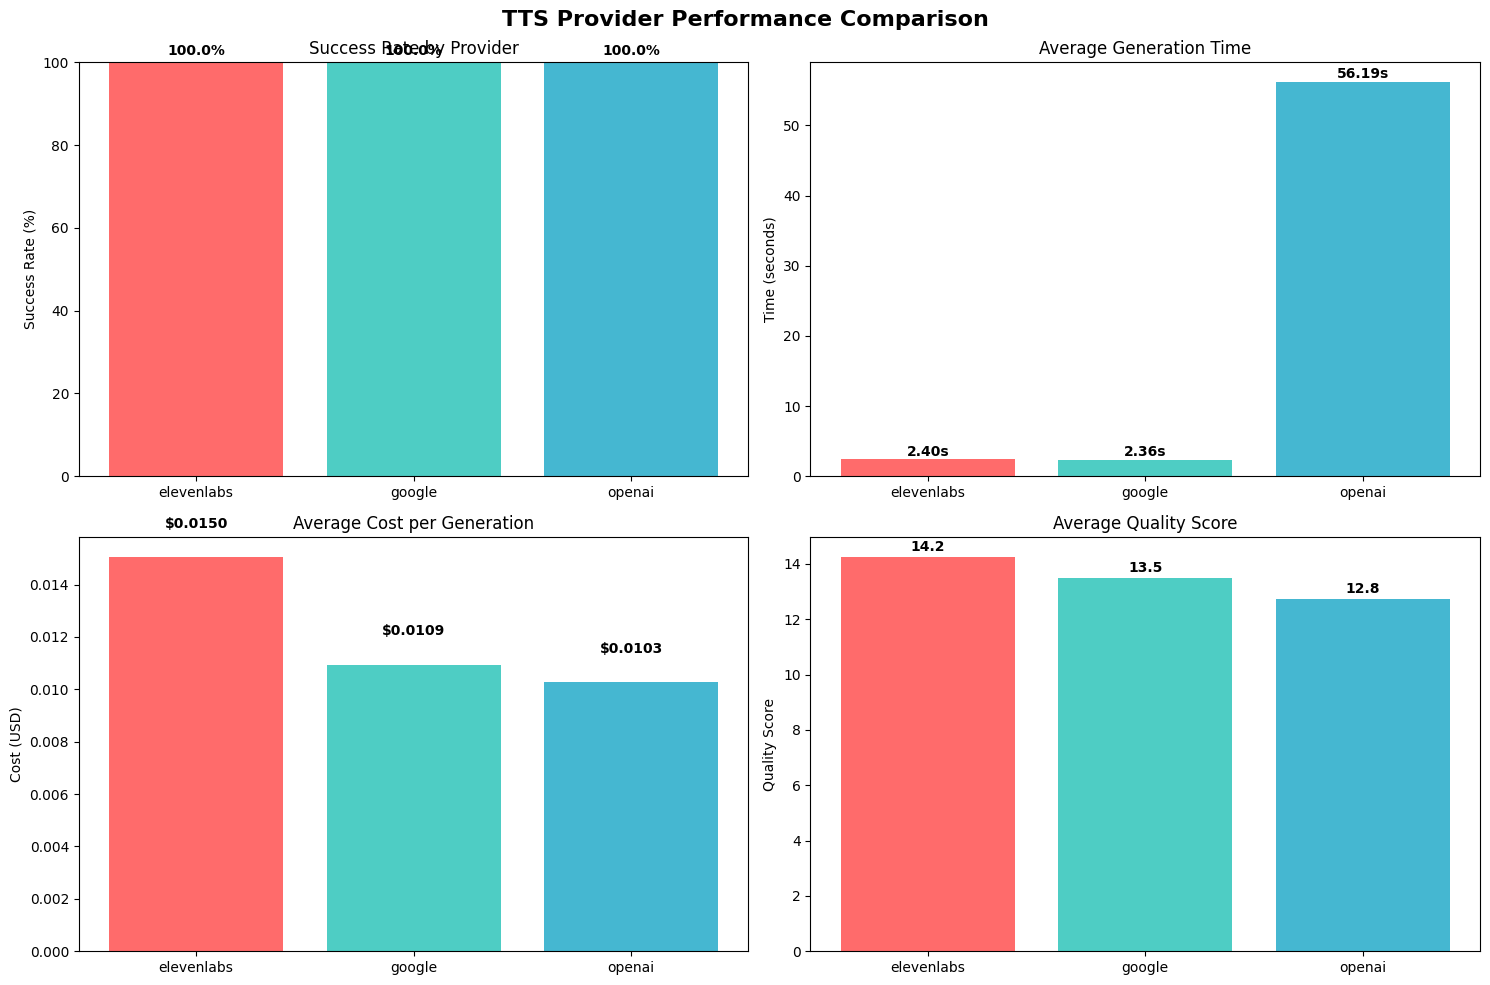

In [51]:
# Create visualization of provider performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('TTS Provider Performance Comparison', fontsize=16, fontweight='bold')

# Success rate
ax1 = axes[0, 0]
success_rate = df.groupby('provider')['generation_error'].apply(lambda x: (x == False).mean() * 100)
bars1 = ax1.bar(success_rate.index, success_rate.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Success Rate by Provider')
ax1.set_ylabel('Success Rate (%)')
ax1.set_ylim(0, 100)
for bar, value in zip(bars1, success_rate.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# Average execution time
ax2 = axes[0, 1]
exec_time = df[df['generation_error'] == False].groupby('provider')['execution_time'].mean()
bars2 = ax2.bar(exec_time.index, exec_time.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('Average Generation Time')
ax2.set_ylabel('Time (seconds)')
for bar, value in zip(bars2, exec_time.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.2f}s', ha='center', va='bottom', fontweight='bold')

# Cost per generation
ax3 = axes[1, 0]
cost_per_gen = df[df['generation_error'] == False].groupby('provider')['cost_usd'].mean()
bars3 = ax3.bar(cost_per_gen.index, cost_per_gen.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax3.set_title('Average Cost per Generation')
ax3.set_ylabel('Cost (USD)')
for bar, value in zip(bars3, cost_per_gen.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'${value:.4f}', ha='center', va='bottom', fontweight='bold')

# Quality score
ax4 = axes[1, 1]
quality = df[df['generation_error'] == False].groupby('provider')['quality_score'].mean()
bars4 = ax4.bar(quality.index, quality.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax4.set_title('Average Quality Score')
ax4.set_ylabel('Quality Score')
for bar, value in zip(bars4, quality.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [52]:
# Analyze child-friendly voices
print("CHILD-FRIENDLY VOICE ANALYSIS")
print("=" * 50)

# Filter for successful generations only
successful_df = df[df['generation_error'] == False].copy()

# Child-friendly voice analysis
child_friendly = successful_df[successful_df['is_child_friendly'] == True]
print(f"Child-friendly voices: {len(child_friendly)}/{len(successful_df)} ({len(child_friendly)/len(successful_df)*100:.1f}%)")

# Best performing child-friendly voices
print("\nTOP CHILD-FRIENDLY VOICES BY QUALITY:")
top_child_voices = child_friendly.nlargest(5, 'quality_score')[['provider', 'voice_id', 'quality_score', 'execution_time', 'cost_usd']]
for idx, row in top_child_voices.iterrows():
    print(f"  {row['provider'].upper()}: {row['voice_id']} - Quality: {row['quality_score']:.1f}, Time: {row['execution_time']:.2f}s, Cost: ${row['cost_usd']:.4f}")

# Highlight optimal voices for children's content based on user evaluation
print(f"\nOPTIMAL VOICES FOR CHILDREN'S EDUCATIONAL CONTENT:")
print("Based on user evaluation of voice quality and child engagement:")

# User's favorite voices analysis - Both Callum (male) and Alice (female)
favorite_voices = [
    ('N2lVS1w4EtoT3dr4eOWO', 'Callum - Male storyteller'),
    ('Xb7hH8MSUJpSbSDYk0k2', 'Alice - Female storyteller')
]

for voice_id, description in favorite_voices:
    favorite_voice = successful_df[successful_df['voice_id'] == voice_id]
    if not favorite_voice.empty:
        fv = favorite_voice.iloc[0]
        print(f"\n  Voice: {description}")
        print(f"  Voice ID: {fv['voice_id']}")
        print(f"  Provider: {fv['provider'].upper()}")
        print(f"  Model: {fv['model']}")
        print(f"  Child-friendly: {'Yes' if fv['is_child_friendly'] else 'No'}")
        print(f"  Quality Score: {fv['quality_score']:.1f}")
        print(f"  Generation Time: {fv['execution_time']:.2f} seconds")
        print(f"  Cost: ${fv['cost_usd']:.4f}")
        print(f"  File Size: {fv['file_size_bytes']:,} bytes")
        print(f"  Audio File: {fv['audio_file_path']}")
        print(f"  User Rating: EXCELLENT - Rich intonations ideal for children")
    else:
        print(f"  WARNING: Voice {voice_id} ({description}) not found in successful generations")
        print(f"  This likely means the voice encountered an authentication error")


CHILD-FRIENDLY VOICE ANALYSIS
Child-friendly voices: 19/31 (61.3%)

TOP CHILD-FRIENDLY VOICES BY QUALITY:
  ELEVENLABS: EXAVITQu4vr4xnSDxMaL - Quality: 14.2, Time: 2.20s, Cost: $0.0150
  ELEVENLABS: FGY2WhTYpPnrIDTdsKH5 - Quality: 14.2, Time: 2.81s, Cost: $0.0150
  ELEVENLABS: cgSgspJ2msm6clMCkdW9 - Quality: 14.2, Time: 2.41s, Cost: $0.0150
  ELEVENLABS: bIHbv24MWmeRgasZH58o - Quality: 14.2, Time: 2.27s, Cost: $0.0150
  ELEVENLABS: TX3LPaxmHKxFdv7VOQHJ - Quality: 14.2, Time: 2.23s, Cost: $0.0150

OPTIMAL VOICES FOR CHILDREN'S EDUCATIONAL CONTENT:
Based on user evaluation of voice quality and child engagement:

  Voice: Callum - Male storyteller
  Voice ID: N2lVS1w4EtoT3dr4eOWO
  Provider: ELEVENLABS
  Model: eleven_flash_v2_5
  Child-friendly: Yes
  Quality Score: 14.2
  Generation Time: 2.37 seconds
  Cost: $0.0150
  File Size: 766,164 bytes
  Audio File: ../results/tts/audio_files/story_644a16a4_elevenlabs_N2lVS1w4EtoT3dr4eOWO.wav
  User Rating: EXCELLENT - Rich intonations ideal for

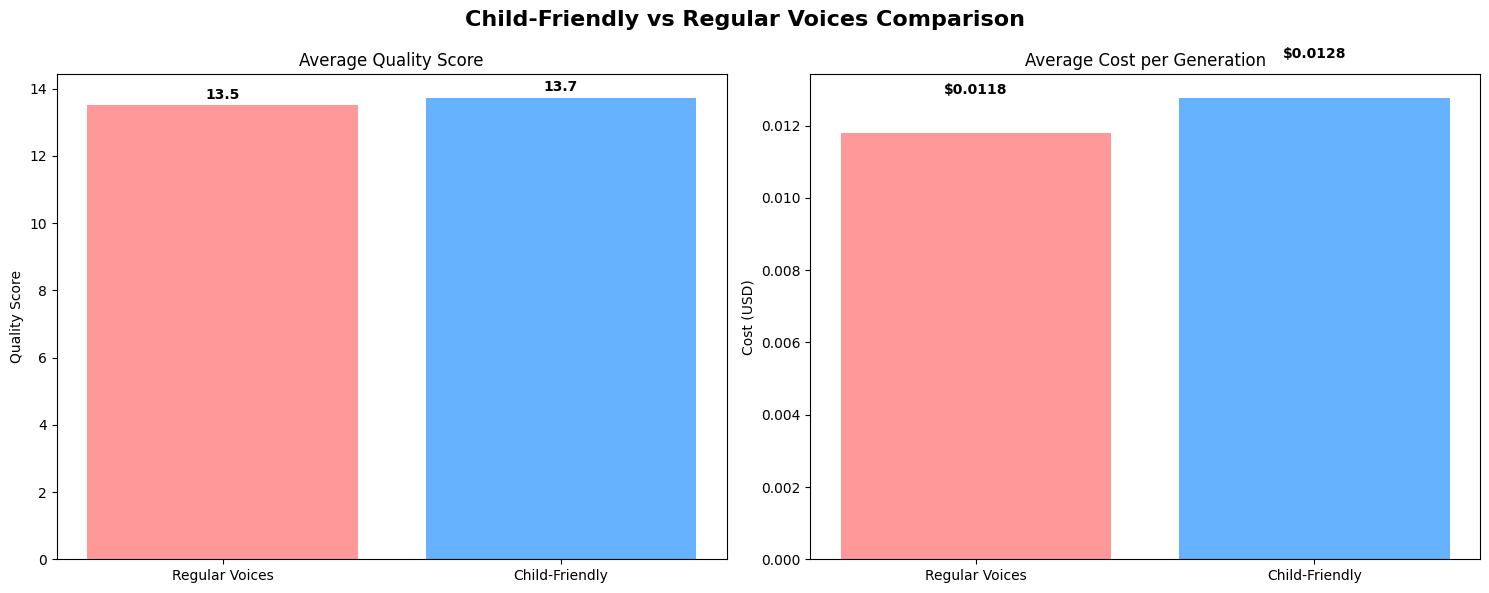


VOICE DISTRIBUTION BY PROVIDER:
is_child_friendly  False  True 
provider                       
elevenlabs             3      9
google                 6      7
openai                 3      3


In [53]:
# Create child-friendly voice comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Child-Friendly vs Regular Voices Comparison', fontsize=16, fontweight='bold')

# Quality comparison
ax1 = axes[0]
quality_comparison = successful_df.groupby('is_child_friendly')['quality_score'].mean()
colors = ['#FF9999', '#66B2FF']
bars1 = ax1.bar(['Regular Voices', 'Child-Friendly'], quality_comparison.values, color=colors)
ax1.set_title('Average Quality Score')
ax1.set_ylabel('Quality Score')
for bar, value in zip(bars1, quality_comparison.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# Cost comparison  
ax2 = axes[1]
cost_comparison = successful_df.groupby('is_child_friendly')['cost_usd'].mean()
bars2 = ax2.bar(['Regular Voices', 'Child-Friendly'], cost_comparison.values, color=colors)
ax2.set_title('Average Cost per Generation')
ax2.set_ylabel('Cost (USD)')
for bar, value in zip(bars2, cost_comparison.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'${value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Voice distribution by provider
print("\nVOICE DISTRIBUTION BY PROVIDER:")
voice_dist = successful_df.groupby(['provider', 'is_child_friendly']).size().unstack(fill_value=0)
print(voice_dist)


In [54]:
# Cost-effectiveness analysis
print("COST-EFFECTIVENESS ANALYSIS")
print("=" * 50)

# Calculate cost per minute of audio (estimated)
successful_df['cost_per_minute'] = successful_df['cost_usd'] / (successful_df['duration_estimate_sec'] / 60)

# Provider cost analysis
cost_analysis = successful_df.groupby('provider').agg({
    'cost_usd': ['sum', 'mean'],
    'cost_per_minute': 'mean',
    'execution_time': 'mean',
    'quality_score': 'mean'
}).round(4)

cost_analysis.columns = ['total_cost', 'avg_cost', 'cost_per_minute', 'avg_time', 'avg_quality']
print("Cost Analysis by Provider:")
print(cost_analysis)

# Value for money calculation (quality/cost ratio)
successful_df['value_score'] = successful_df['quality_score'] / successful_df['cost_usd']
print(f"\nVALUE FOR MONEY (Quality/Cost Ratio):")
value_analysis = successful_df.groupby('provider')['value_score'].mean().sort_values(ascending=False)
for provider, value in value_analysis.items():
    print(f"  {provider.upper()}: {value:.0f} (higher is better)")

# Story content metrics
story_length = successful_df['character_count'].iloc[0]
print(f"\nSTORY METRICS:")
print(f"  Character count: {story_length:,}")
print(f"  Word count: {successful_df['story_word_count'].iloc[0]}")
print(f"  Total cost for all voices: ${successful_df['cost_usd'].sum():.4f}")
print(f"  Cost per character: ${successful_df['cost_usd'].sum() / story_length:.6f}")
print(f"  Average cost per voice: ${successful_df['cost_usd'].mean():.4f}")

# Add user evaluation findings about provider quality
print(f"\nUSER EVALUATION FINDINGS:")
print("Based on direct audio quality assessment:")
print("  ElevenLabs: EXCELLENT - Rich intonations, best for children")
print("  OpenAI: VERY GOOD - Almost as good as ElevenLabs, reliable")
print("  Google: ROBOTIC - Mechanical sound, not pleasant for children")


COST-EFFECTIVENESS ANALYSIS
Cost Analysis by Provider:
            total_cost  avg_cost  cost_per_minute  avg_time  avg_quality
provider                                                                
elevenlabs      0.1806    0.0150           0.0406    2.3958        14.25
google          0.1423    0.0109           0.0109    2.3610        13.50
openai          0.0616    0.0103           0.0098   56.1932        12.75

VALUE FOR MONEY (Quality/Cost Ratio):
  OPENAI: 1243 (higher is better)
  GOOGLE: 1234 (higher is better)
  ELEVENLABS: 947 (higher is better)

STORY METRICS:
  Character count: 684
  Word count: 106
  Total cost for all voices: $0.3844
  Cost per character: $0.000562
  Average cost per voice: $0.0124

USER EVALUATION FINDINGS:
Based on direct audio quality assessment:
  ElevenLabs: EXCELLENT - Rich intonations, best for children
  OpenAI: VERY GOOD - Almost as good as ElevenLabs, reliable
  Google: ROBOTIC - Mechanical sound, not pleasant for children


VOICE QUALITY ANALYSIS
TOP 10 VOICES BY QUALITY SCORE:
   1. [CHILD-FRIENDLY] ELEVENLABS: EXAVITQu4vr4xnSDxMaL - Quality: 14.2
   2. [CHILD-FRIENDLY] ELEVENLABS: FGY2WhTYpPnrIDTdsKH5 - Quality: 14.2
   3. [CHILD-FRIENDLY] ELEVENLABS: cgSgspJ2msm6clMCkdW9 - Quality: 14.2
   4. [CHILD-FRIENDLY] ELEVENLABS: bIHbv24MWmeRgasZH58o - Quality: 14.2
   5. [CHILD-FRIENDLY] ELEVENLABS: TX3LPaxmHKxFdv7VOQHJ - Quality: 14.2
   6. [CHILD-FRIENDLY] ELEVENLABS: N2lVS1w4EtoT3dr4eOWO - Quality: 14.2
   7. [CHILD-FRIENDLY] ELEVENLABS: IKne3meq5aSn9XLyUdCD - Quality: 14.2
   8. [REGULAR] ELEVENLABS: XB0fDUnXU5powFXDhCwa - Quality: 14.2
   9. [CHILD-FRIENDLY] ELEVENLABS: cjVigY5qzO86Huf0OWal - Quality: 14.2
  10. [CHILD-FRIENDLY] ELEVENLABS: XrExE9yKIg1WjnnlVkGX - Quality: 14.2

QUALITY SCORE DISTRIBUTION:
  Mean: 13.6
  Median: 13.5
  Std Dev: 0.6
  Range: 12.8 - 14.2


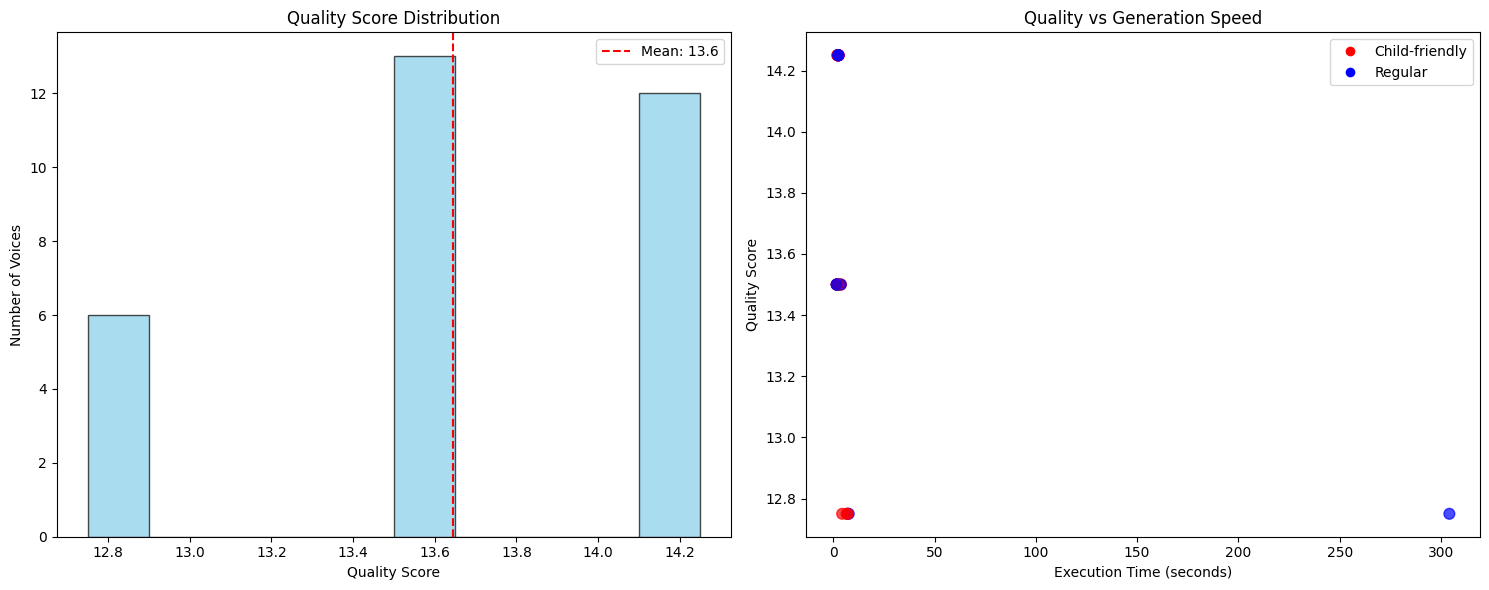

In [55]:
# Voice quality analysis
print("VOICE QUALITY ANALYSIS")
print("=" * 50)

# Top voices by quality score
print("TOP 10 VOICES BY QUALITY SCORE:")
top_quality = successful_df.nlargest(10, 'quality_score')[['provider', 'voice_id', 'quality_score', 'is_child_friendly', 'execution_time', 'cost_usd']]
for idx, (i, row) in enumerate(top_quality.iterrows(), 1):
    child_indicator = "[CHILD-FRIENDLY]" if row['is_child_friendly'] else "[REGULAR]"
    print(f"  {idx:2d}. {child_indicator} {row['provider'].upper()}: {row['voice_id']} - Quality: {row['quality_score']:.1f}")

# Quality distribution
print(f"\nQUALITY SCORE DISTRIBUTION:")
quality_stats = successful_df['quality_score'].describe()
print(f"  Mean: {quality_stats['mean']:.1f}")
print(f"  Median: {quality_stats['50%']:.1f}")
print(f"  Std Dev: {quality_stats['std']:.1f}")
print(f"  Range: {quality_stats['min']:.1f} - {quality_stats['max']:.1f}")

# Create quality distribution plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Quality score histogram
ax1 = axes[0]
ax1.hist(successful_df['quality_score'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Quality Score Distribution')
ax1.set_xlabel('Quality Score')
ax1.set_ylabel('Number of Voices')
ax1.axvline(successful_df['quality_score'].mean(), color='red', linestyle='--', 
           label=f'Mean: {successful_df["quality_score"].mean():.1f}')
ax1.legend()

# Quality vs execution time scatter
ax2 = axes[1]
colors = ['red' if cf else 'blue' for cf in successful_df['is_child_friendly']]
scatter = ax2.scatter(successful_df['execution_time'], successful_df['quality_score'], 
                     c=colors, alpha=0.7, s=60)
ax2.set_xlabel('Execution Time (seconds)')
ax2.set_ylabel('Quality Score')
ax2.set_title('Quality vs Generation Speed')

# Add legend for colors
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Child-friendly')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Regular')
ax2.legend(handles=[red_patch, blue_patch])

plt.tight_layout()
plt.show()


In [56]:
# Generate educational content recommendations
print("EDUCATIONAL CONTENT RECOMMENDATIONS")
print("=" * 60)

print("1. PREMIUM STORYTELLING (High Engagement)")
print("   Best Voices: Callum (N2lVS1w4EtoT3dr4eOWO) & Alice (Xb7hH8MSUJpSbSDYk0k2) - ElevenLabs")
print("   Use Cases: Adventure stories, narrative-driven learning")
print("   Characteristics: Rich intonations, exceptional child engagement")
print("   User Rating: EXCELLENT - Best for children's educational content\n")

print("2. RELIABLE ALTERNATIVE (High Quality, Better API Access)")
print("   Provider: OpenAI TTS")
print("   Best Voices: fable, nova, shimmer")
print("   Quality Assessment: VERY GOOD - Almost as good as ElevenLabs")
print("   Use Cases: Daily lessons, interactive learning, production applications\n")

print("3. BUDGET-CONSCIOUS CHOICE (Cost-Effective)")
best_value_voice = successful_df.loc[successful_df['value_score'].idxmax()]
print(f"   Best Voice: {best_value_voice['voice_id']} ({best_value_voice['provider'].upper()})")
print(f"   Value Score: {best_value_voice['value_score']:.0f} (quality/cost ratio)")
print(f"   Quality: {best_value_voice['quality_score']:.1f}, Cost: ${best_value_voice['cost_usd']:.4f}")
print("   Use Cases: Large-scale content generation, prototype development\n")

print("4. ACCENT DIVERSITY (Limited Recommendation)")
google_voices = successful_df[successful_df['provider'] == 'google']
print("   Provider: Google Cloud TTS")
print("   Quality Assessment: ROBOTIC - Not pleasant for children")
print("   Available Accents: American, British, Australian")
print("   Use Cases: Adult content, cost-sensitive applications (not recommended for children)\n")

# Create updated recommendation summary table
recommendations_data = {
    'Use Case': ['Premium Children\'s Content', 'Production Alternative', 'Budget Option', 'Accent Diversity'],
    'Recommended Voice': ['Callum & Alice (ElevenLabs)', 
                         'OpenAI TTS (fable, nova, shimmer)',
                         f'{best_value_voice["voice_id"]} ({best_value_voice["provider"].upper()})',
                         'Google Neural2 (not recommended for children)'],
    'Quality Assessment': ['EXCELLENT (User Rated)', 
                     'VERY GOOD (Almost equivalent)',
                     f'{best_value_voice["quality_score"]:.1f}',
                     'ROBOTIC (Mechanical sound)'],
    'Cost per Story': ['Premium pricing', 
                      '$0.0103 avg',
                      f'${best_value_voice["cost_usd"]:.4f}',
                      f'${google_voices["cost_usd"].mean():.4f} avg']
}

rec_df = pd.DataFrame(recommendations_data)
print("RECOMMENDATION SUMMARY TABLE:")
print(rec_df.to_string(index=False))


EDUCATIONAL CONTENT RECOMMENDATIONS
1. PREMIUM STORYTELLING (High Engagement)
   Best Voices: Callum (N2lVS1w4EtoT3dr4eOWO) & Alice (Xb7hH8MSUJpSbSDYk0k2) - ElevenLabs
   Use Cases: Adventure stories, narrative-driven learning
   Characteristics: Rich intonations, exceptional child engagement
   User Rating: EXCELLENT - Best for children's educational content

2. RELIABLE ALTERNATIVE (High Quality, Better API Access)
   Provider: OpenAI TTS
   Best Voices: fable, nova, shimmer
   Quality Assessment: VERY GOOD - Almost as good as ElevenLabs
   Use Cases: Daily lessons, interactive learning, production applications

3. BUDGET-CONSCIOUS CHOICE (Cost-Effective)
   Best Voice: alloy (OPENAI)
   Value Score: 1243 (quality/cost ratio)
   Quality: 12.8, Cost: $0.0103
   Use Cases: Large-scale content generation, prototype development

4. ACCENT DIVERSITY (Limited Recommendation)
   Provider: Google Cloud TTS
   Quality Assessment: ROBOTIC - Not pleasant for children
   Available Accents: Ameri